In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, SeasonalNaive

from sklearn.metrics import mean_absolute_percentage_error, root_mean_squared_error

import warnings
warnings.filterwarnings("ignore")

This notebook will be exploring more capabilities of the StatsForecast Python Module using the [Hourly Energy Consumption Dataset](https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption). There are many companies included, but for simplicity, I am just going to use AEP. 

I will also only consider a few months of data, even though this dataset provides much more. Since the data is hourly, a few months will be plenty.

The data has two seasonalities: daily and hourly. This will allow me to try a couple of models with different abilities. 

In [2]:
# read in the data
df = pd.read_csv('AEP_hourly.csv')
df['Datetime'] = pd.to_datetime(df['Datetime'])

# apply module naming convention
df.rename({'Datetime':'ds', 'AEP_MW':'y'}, axis=1 , inplace=True)
df['unique_id'] = 'aep'

# narrow down date range. dates selected are arbitrary
df2 = df[(df['ds']>= '2018-01-01') & (df['ds']< '2018-05-01')].sort_values('ds', ascending=True)
df = df[(df['ds']>= '2018-01-01')].sort_values('ds', ascending=True)

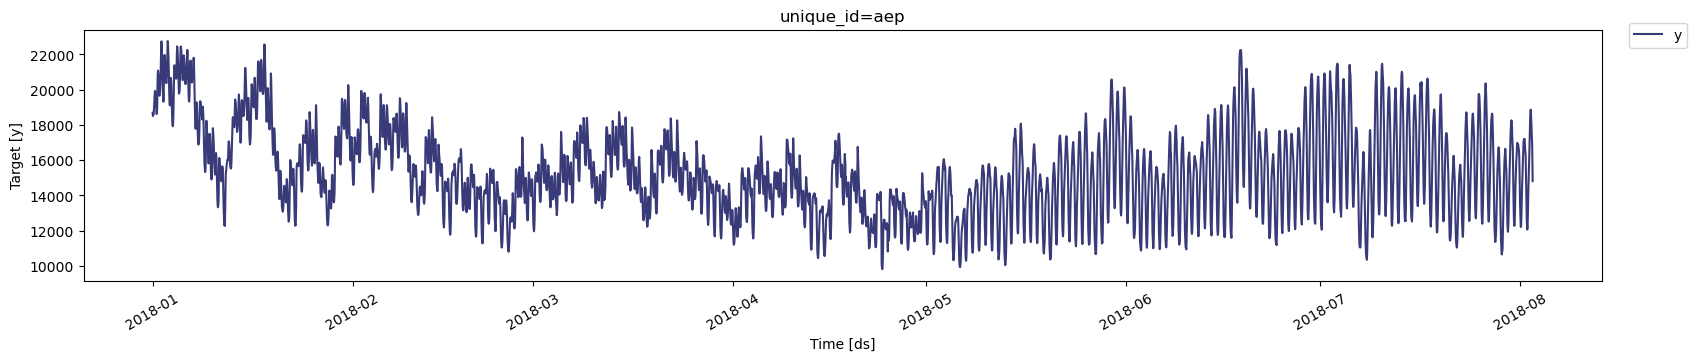

In [3]:
StatsForecast.plot(df)

In [4]:
# split data for training and evaluation
# test on 2 days so I can forecast on 2 days after
train = df.iloc[:-48]
test = df.iloc[-48:]

season_length=24

In [5]:
# define and fit model, takes about 5 mins to fit
sf = StatsForecast(models = [     
    AutoARIMA(season_length=season_length),                  
    SeasonalNaive(season_length=season_length),                                  
],
freq = 'H') 

sf.fit(train)


StatsForecast(models=[AutoARIMA,SeasonalNaive])

In [6]:
# forecast 2 days and evaluate using RMSE and MAPE
predictions = sf.predict(h=test['ds'].nunique())
predictions = test.merge(predictions, how = 'left')

models = ['AutoARIMA','SeasonalNaive']

metrics = []
for m in models:
        rmse = root_mean_squared_error(predictions['y'], predictions[m])
        mape = mean_absolute_percentage_error(predictions['y'], predictions[m])
        metrics.append({'Model': m, 'RMSE': rmse, 'MAPE': mape})


# find best performing model for each category using RMSE
metrics = pd.DataFrame(metrics)
metrics.sort_values('RMSE', ascending=True)

,Model,RMSE,MAPE
0,AutoARIMA,456.284180,0.019157
1,SeasonalNaive,691.067818,0.027236


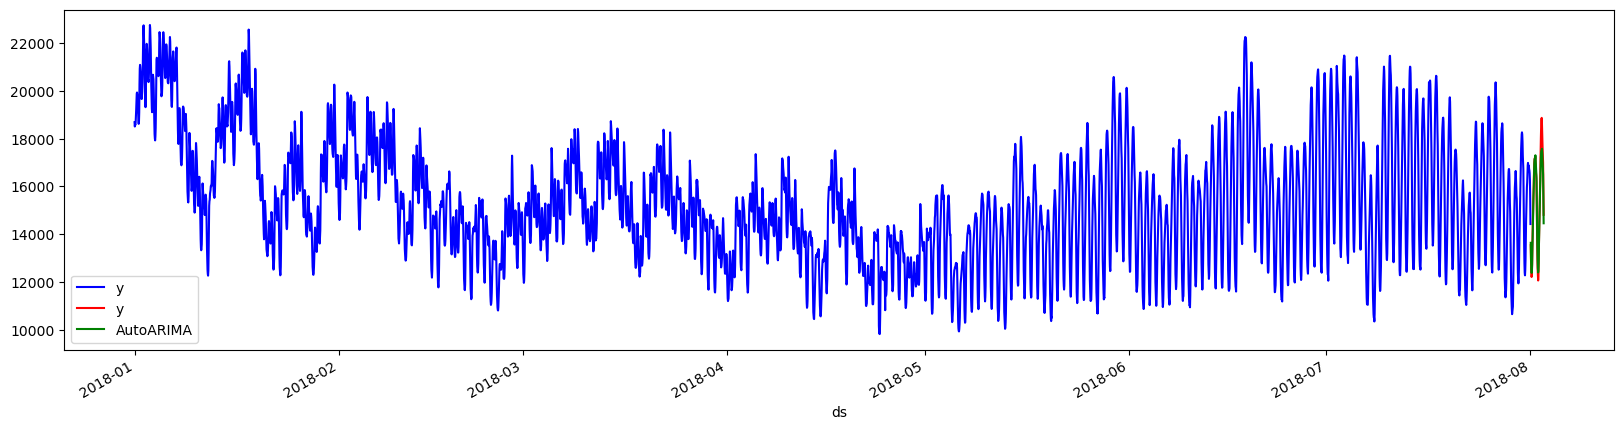

In [7]:
# plot AutoARIMA since it has lower RMSE
ax = train.set_index('ds').plot(color='blue', label = 'Train', figsize=(20,5))
test[['ds', 'y']].set_index('ds').plot(ax=ax, color='red', label = 'Test')
predictions[['ds', 'AutoARIMA']].set_index('ds').plot(ax=ax, color='green', label = 'Prediction')
plt.show();

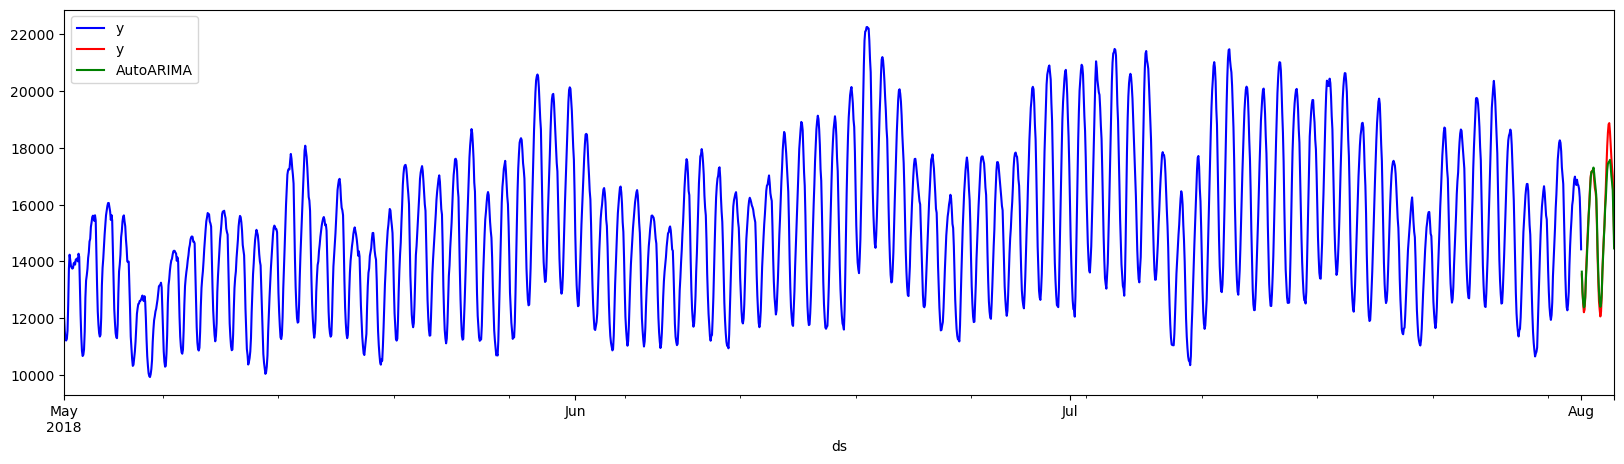

In [8]:
# zoom in on the plot
ax = train[train['ds'] >= '2018-05-01'].set_index('ds').plot(color='blue', label = 'Train', figsize=(20,5))
test[['ds', 'y']].set_index('ds').plot(ax=ax, color='red', label = 'Test')
predictions[['ds', 'AutoARIMA']].set_index('ds').plot(ax=ax, color='green', label = 'Prediction')
plt.show();

This looks pretty good.  I can try another method, MSTL, to see the RMSE can be reduced.

*** 
## MSTL

In this section, I will try out Multiple Seasonal-Trend decomposition using LOESS (MSTL). As mentioned at the top, the dataset exhibits multiple seasonalities -- hourly and daily -- which MSTL is well-equipped to handle.

I will also explore and make use of the methods in utilsforecast. 

In [9]:
from utilsforecast.plotting import plot_series
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import  mape, mase, rmse
from statsforecast.models import MSTL, AutoARIMA

from functools import partial

In [10]:
sf = StatsForecast(
    models=[MSTL(season_length=[24, 24 * 7], # define hourly, daily seasonality
    trend_forecaster=AutoARIMA())], 
    freq='H', 
)

# can use the same train-test split from earlier
sf = sf.fit(df=train)

# see summary of model components
sf.fitted_[0, 0].model_

,data,trend,seasonal24,seasonal168,remainder
0,18687.0,20698.828688,-423.912092,-707.552552,-880.364043
1,18508.0,20695.175238,-786.602056,-565.468497,-835.104686
2,18600.0,20691.458645,-890.825935,-455.065031,-745.567679
3,18571.0,20687.678086,-898.083630,-391.816693,-826.777763
4,18686.0,20683.832752,-785.551635,-280.335127,-931.945990
...,...,...,...,...,...
5083,16674.0,14662.027759,2013.412084,354.538875,-355.978718
5084,16556.0,14654.758782,1543.787311,444.283537,-86.829630
5085,16252.0,14647.470903,1201.776050,456.524814,-53.771767
5086,15504.0,14640.164448,228.082611,429.645178,206.107763


The decomposed plot very clearly shows the multiple seasonalities: hourly (green plot) and daily (red plot).

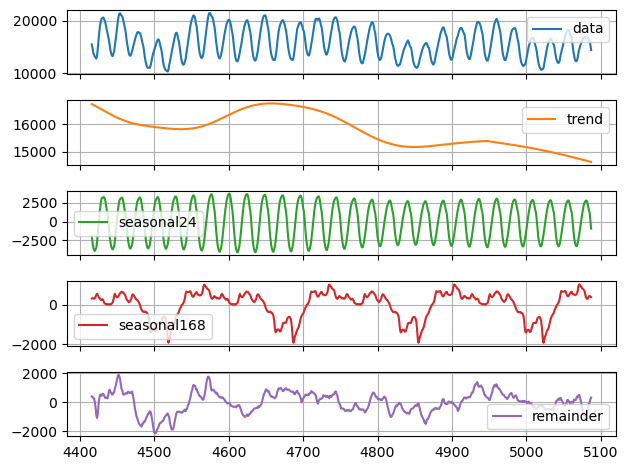

In [11]:
# look at the decomposition of the data once now there's a fitted model
sf.fitted_[0, 0].model_.tail(24 * 28).plot(subplots=True, grid=True)
plt.tight_layout()
plt.show()

In [12]:
# now let's forecast
forecasts = sf.predict(h=48, level=[90])
forecasts.head()

,unique_id,ds,MSTL,MSTL-lo-90,MSTL-hi-90
0,aep,2018-08-01 01:00:00,13382.460323,13218.682314,13546.238332
1,aep,2018-08-01 02:00:00,12784.598832,12494.378002,13074.819661
2,aep,2018-08-01 03:00:00,12384.034795,11960.238381,12807.831210
3,aep,2018-08-01 04:00:00,12137.293574,11586.350797,12688.236352
4,aep,2018-08-01 05:00:00,12146.748328,11475.649590,12817.847067


In [13]:
# evaluate model using same metrics as above
eval_df = evaluate(
    df=test.merge(forecasts),
    train_df=train,
    metrics=[partial(mase, seasonality=24), rmse, mape],
    agg_fn='mean',
).set_index('metric').T
eval_df

metric,mase,rmse,mape
MSTL,0.352959,400.416086,0.022954


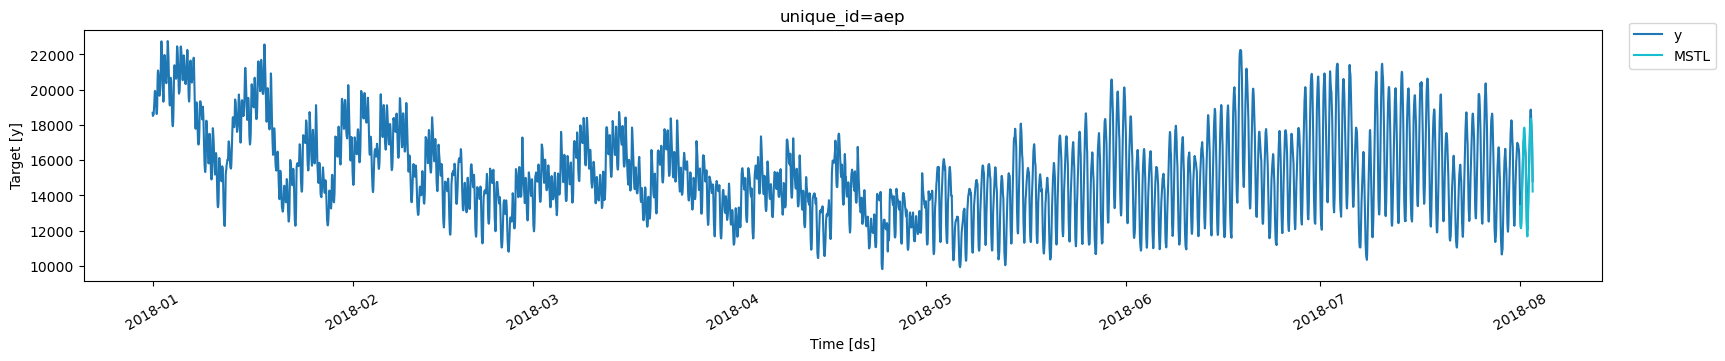

In [14]:
# now let's plot
plot_series(train, test.merge(forecasts))

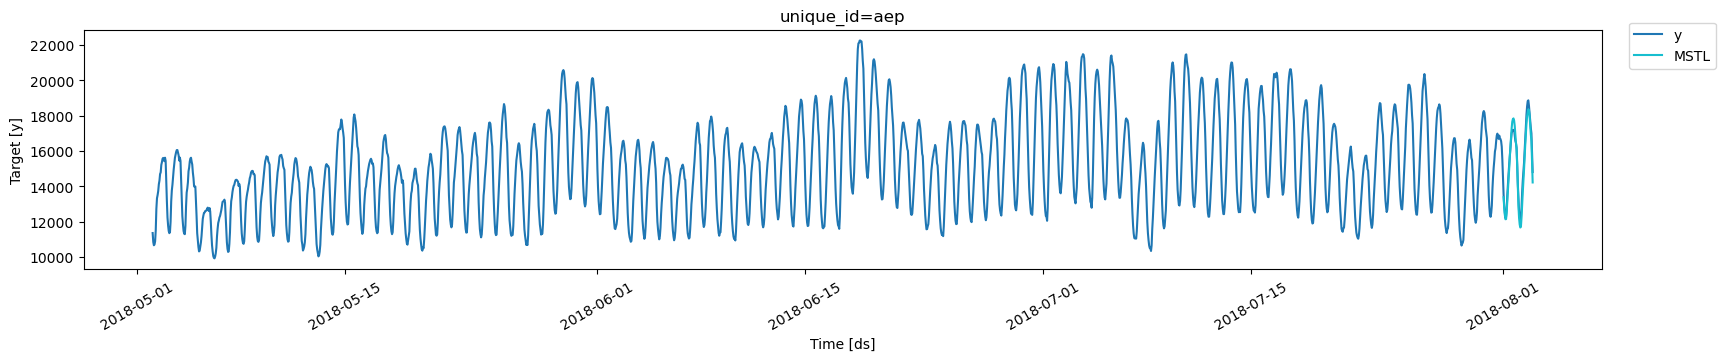

In [15]:
# zoom in on the plot
plot_series(train, test.merge(forecasts),  max_insample_length=24*7*13)

As visually shown, and as reported in the RMSE, MSTL yields slightly better performance. This method is also significantly faster to run. Nice!